# Algorithme ARIMA et SARIMA

Ce Notebook permet d'exécuter l'algorithme **ARIMA** ou **SARIMA** pour résoudre le problème <font color = 'red'> **task1** </font>.

## Avant-propos

Dans cette section, on cherche à résoudre le problème intitulé <font color = 'red'> **task1** </font> c'est-à-dire à prédire la variable réponse `NB_DOSS_DAY` qui est le nombre de dossiers qui arrivent au backOffice par jour ou par semaine. 

Pour rappel, voici la table des données crédit avec la variable réponse : 

| Index | `DATEDI`   | `DELAI` | `TAINT`    |...|`NB_DOSS_DAY`|
|-------|------------|---------|----------  |---|-------------| 
|0	    |2017-10-19  |	 2	   | 2.4266	    |...|1            |
|1	    |2017-11-24	 |   0	   |1.6625	    |...|1            |
|2	    |2017-12-13  |  140	   |1.5104      |...|1            |
|3	    |2017-12-14  |	41     |	1.8146  |...|1            |
|4	    |2018-01-05  |	37     |	0.0000	|...|5            |
|...    |	...	     |...	   |...         |...|...          |
|42654  |2022-12-29  |	85     |	2.1305  |...|4            |
|42655  |2022-12-29  |	85     |	1.8658  |...|4            |
|42656  |2022-12-29  |	71     |	2.4777  |...|4            |
|42657  |2022-12-30  |	56     |	2.6312  |...|2            |
|42658  |2022-12-30  |	56     |	2.2938  |...|2            |

On voit que plusieurs crédits peuvent être édités pour la même date. Or, pour avoir une série temporelle (ST), il ne faut pas de doublons dans les dates. On va donc aggréger les données correspondant à une même date en prenant la classe majoritaire pour les variables qualitatives et la valeur moyenne pour les variables quantitatives.

Un autre problème est que les données temporelles ne sont pas continues dans le temps (nous n'avons pas une donnée tous les jours). Lorsque nous cherchons à faire de l'univarié c'est à dire à prédire `NB_DOSS_DAY` en fonction du temps seulement, nous pouvons ajouter des lignes aux journées manquantes et mettre pour ces lignes `NB_DOSS_DAY` = 0. Cependant, si nous voulons faire du multivarié, nous ne pouvons pas ajouter des lignes aux endroits où il manque des jours car il faudrait alors ajouter des valeurs pour toutes les autres variables ce qui n'est pas possible car ces valeurs sont inconnues. On peut peut-être aggréger les données par semaine (mais  de la même façon, il faut trouver des règles pour aggréger les données à la semaine et des règles pour trouver des valeurs pour les semaines où nous n'avons pas de crédits).

In [1]:
# Importation des packages nécessaires
# ---------------------------------------
# Importation des librairies python
import pandas as pd 
import numpy as np
import os

from ipywidgets import interact, fixed
import ipywidgets as widgets

# Importation des librairies du répertoire courant
from set_path import PATH,PATH_DATA,PATH_UTILS,PATH_PLOTS

# Importation des librairies du répertoire utilities
os.chdir(PATH_UTILS) # on se place dans utilities
from set_global import *
import data_prep_general as dpg
import data_viz as dv
import data_prep_task1 as dp1 
import denoising as dn
from denoising import arg_dash
import sarima as sa

print(">>> Pour savoir utiliser la fonction 'fct' de package 'lib' exécuter : help(lib.fct)")

>>> Pour savoir utiliser la fonction 'fct' de package 'lib' exécuter : help(lib.fct)


In [2]:
# Affichage des variables sélectionnées dans le Notebook run_data_viz.ipynb pour la task1
# ---------------------------------------
print("Affichage des variables sélectionnées pour la task1")
print("VAR_REP_1 :", VAR_REP_1)
print("VAR_DATE_CREDIT_1 :", VAR_DATE_CREDIT_1)
print("VAR_QUANTI_CREDIT_1 :", VAR_QUANTI_CREDIT_1)
print("VAR_QUALI_CREDIT_1 :", VAR_QUALI_CREDIT_1)
print("VAR_QUANTI_CREDIT_1_f :", VAR_QUANTI_CREDIT_1_f)
print("VAR_QUANTI_CREDIT_1_i :", VAR_QUANTI_CREDIT_1_i)

Affichage des variables sélectionnées pour la task1
VAR_REP_1 : ['NB_DOSS_DAY']
VAR_DATE_CREDIT_1 : ['DATEDI']
VAR_QUANTI_CREDIT_1 : ['MEDOS', 'TAINT', 'TITEGI', 'QLDDOS', 'NBASSGPE', 'NBASSEXT', 'NBGAR', 'DELINS', 'DELDEC', 'DELEDI', 'CONSCE']
VAR_QUALI_CREDIT_1 : ['COPROG', 'COOBJ', 'TOPPSC', 'LIBLGG']
VAR_QUANTI_CREDIT_1_f : ['MEDOS', 'TAINT', 'TITEGI']
VAR_QUANTI_CREDIT_1_i : ['QLDDOS', 'NBASSGPE', 'NBASSEXT', 'NBGAR', 'DELINS', 'DELDEC', 'DELEDI', 'CONSCE']


## Data pre-processing

Data pre-processing nécessaire pour l'exécution de miniRocket

In [3]:
# Récupération des jeux de données
# ------------------------------------
#--- dataset CEMP
credits_CEMP = pd.read_csv(PATH_DATA + "/CEMP - Données CREDITS.csv", encoding='utf8', sep=';')
credits = credits_CEMP.copy()

# Pré-processing général de certaines variables (cas particuliers)
# ------------------------------------
credits = dpg.special_treatment(credits)

# Transformation des dates au format datetime
# -------------------------------------------
credits = dpg.type_date(credits,VAR_DATE_CREDIT)

# Interpolation des valeurs manquantes des variables dates
# -------------------------------------------
credits = dpg.interpolate_date(credits,VAR_DATE_CREDIT)

# Trier le dataframe par dates croissantes
# -------------------------------------------
credits = dpg.sort_by_date(credits)

# Ajout nombre de crédits par jour
# -----------------------------------------------
credits = dpg.compute_NB_DOSS_DAY(credits)

## Imputation des données

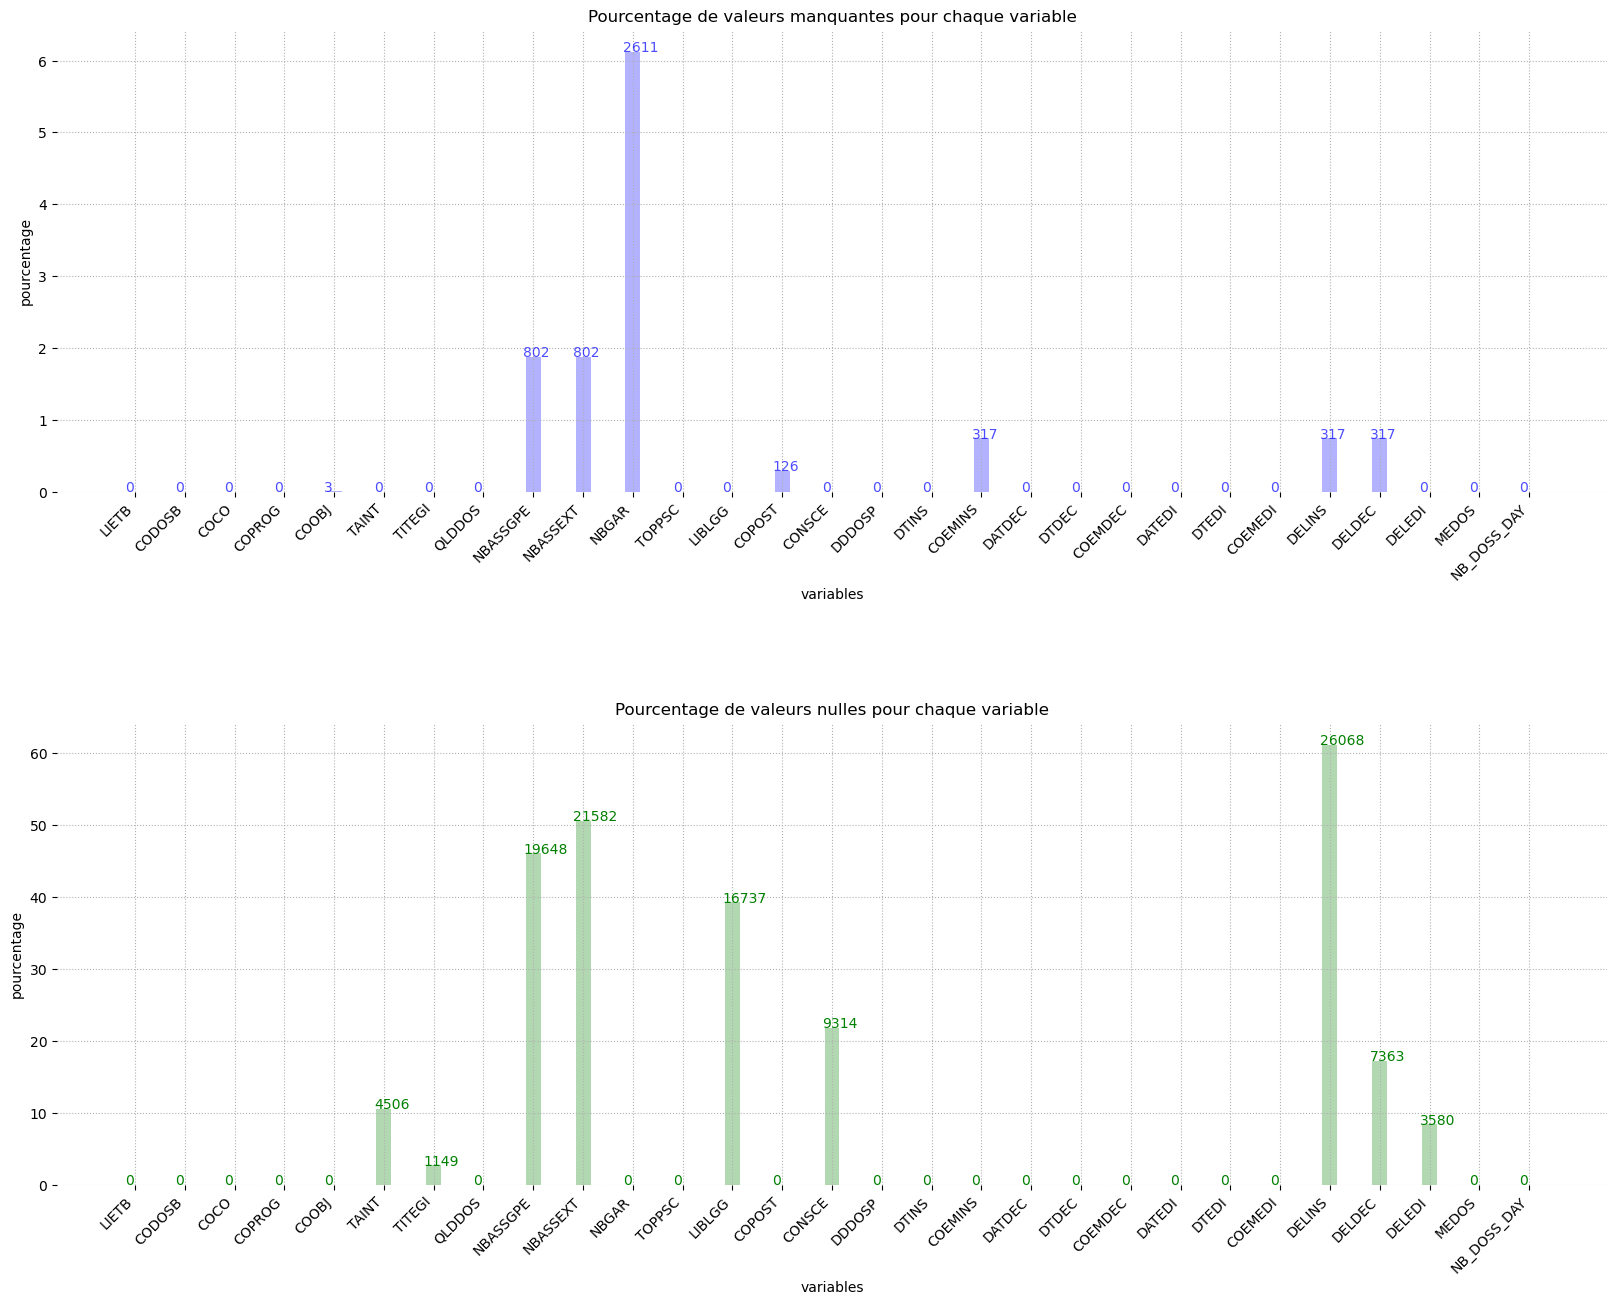

In [4]:
dv.plot_na_null(credits,credits.columns,fig_size=[20,15],plot_null=True)

**Observations:**

Parmi les variables que l'on va sélectionner, on observe des variables manquantes pour:
- `NBGAR` (Nbre de garanties) $\rightarrow$ on observe des valeurs manquantes pour `NBGAR` et aucune valeur nulle. On en déduit que lorsqu'un client n'a pas de garanties, la variable est manquante. On met donc toutes les variables manquantes de `NBGAR` à 0.
- `DELINS` (Nbre jours Instruction) $\rightarrow$ on sait que `DELINS` = `DTINS`(Date instruction traitée) - `DDD0SP`(Date instruction à traiter). Or nous avons déjà interpolé la variable `DTINS` et la variable `DDD0SP` n'est pas manquante. Nous pouvons donc calculer les valeurs manquantes de `DELINS`. 
- `DELDEC` (Nbre jrs Décision) $\rightarrow$ on sait que `DELDEC` = `DTDEC`(Date accord banque traitée) - `DATDEC`(Date accord banque à traiter). Or nous avons déjà interpolé la variable `DATDEC` et la variable `DTDEC` n'est pas manquante. Nous pouvons donc calculer les valeurs manquantes de `DELDEC`
- `NBASSGPE`(Nbre Assurance Groupe) et `NBASSEXT`(Nbre Assurance Externe)  $\rightarrow$  on observe le même nombre de valeurs manquantes pour ces 2 variables et après calcul on voit que les valeurs sont manquantes aux mêmes endroits pour ces deux variables. Or, un client est supposé posseder soit une assurance de groupe, soit une assurance externe. De plus, on voit que `NBASSGPE` et `NBASSEXT` ont environ le même nombre de 0. Pour un dossier dont l'assurance est manquante, on va donc tirer aléatoirement (avec proba 1/2) une assurance entre `NBASSGPE` et `NBASSEXT`, par exemple `NBASSGPE`. On met la valeur de `NBASSGPE` à 0 et on prend pour `NBASSEXT`, la moyenne. 
-  `COOBJ` (Code objet prêt) $\rightarrow$ possède très peu de valeurs manquantes. On impute par la modalité majoritaire.

In [5]:
# Imputation des données manquantes 
# -------------------------------------
credits = dp1.fill_na_1(credits)

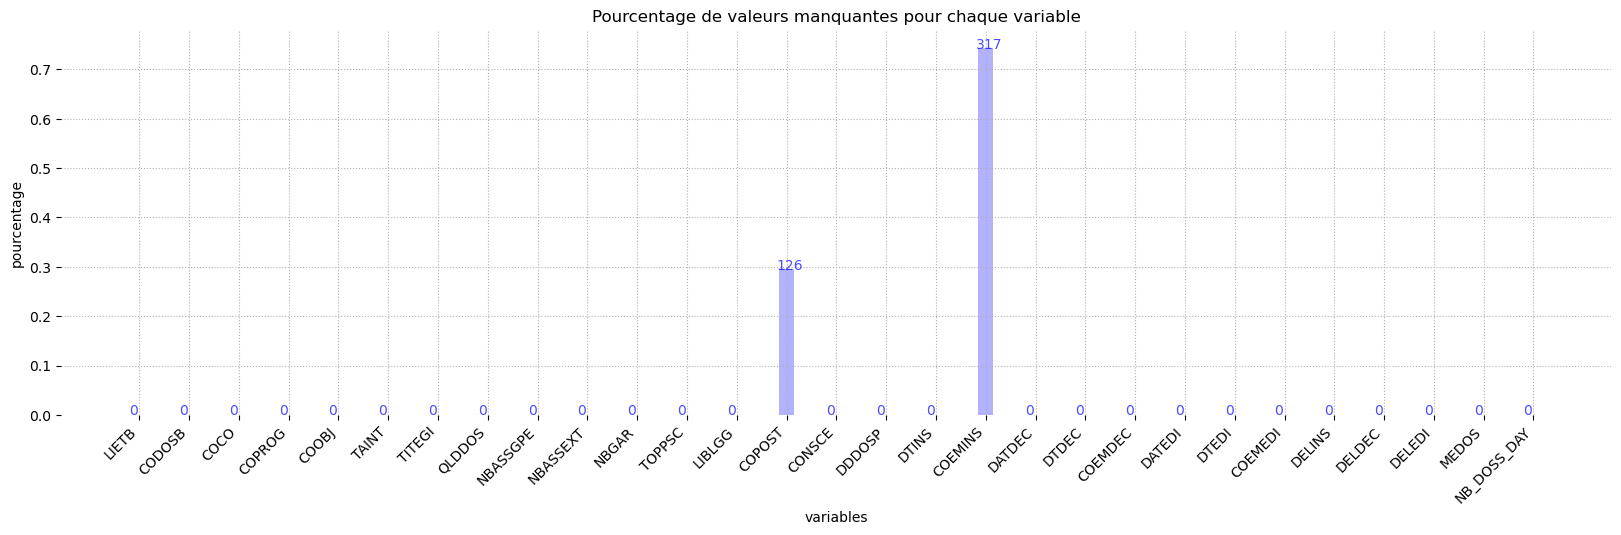

In [6]:
# Vérification qu'il ne reste plus de variables manquantes
# -------------------------------------
dv.plot_na_null(credits,credits.columns,fig_size=[20,5],plot_null=False)

## Cas Univarié

### Création TS

TS : Time Series = série temporelle univariée.

Afin d'avoir le format d'une Série Temporelle, on compte le nombre de crédits par jour (ou par semaine) et on met la valeur 0 si il n'y a pas de crédits. La série temporelle obtenue est continue dans le temps (les dates se suivent tous les jours ou toutes les semaines).

In [7]:
# Définition de séries temporelles univariées 
# ----------------------------------------------
# Données regroupées par jour
TS_day   = dp1.create_TS(credits,by='day')
# Données regroupées par buisiness day (jour sans le dimanche)
TS_day_B = dp1.create_TS(credits,by='business_day')
# Données regroupées par semaine
TS_week  = dp1.create_TS(credits,by='week')

### Débruitage

In [8]:
# Exploration des paramètres de  débruitage pour trouver les meilleurs paramètres 
# ----------------------------------------------
_ = interact(dn.plot_dash_debruitTrans, **arg_dash, 
             TS_week=fixed(TS_week), TS_day=fixed(TS_day))

interactive(children=(ToggleButtons(button_style='success', description='signal', options=('TS_week', 'TS_day'…

**Observations:**

Après réglage des paramètres, on retient les valeurs :

- pour TS_day: wave='sym19', seuil=0.5, translation=8 (on ne peut pas trop débruiter au risque de perdre beaucoup d'information.)

- pour TS_week: wave='sym11',seuil=1.5, translation=8

In [9]:
# Une fois que l'on a trouvé les bons paramètres avec le panel ci-dessus, on définit le signal débruité
# ----------------------------------------------
TSrec_day,_  = dn.DebruitTrans(TS_day,qmf='db3',T=.5,trans=8)
TSrec_week,_ = dn.DebruitTrans(TS_week,qmf='sym11',T=1.5,trans=8) #'db9'

### Données regroupées par semaine

Pour la démarche, nous nous appuirons sur le lien suivant : https://otexts.com/fpp2/weekly.html qui indique que :

Il est difficile de travailler avec des données hebdomadaires car la période saisonnière (le nombre de semaines dans une année) est à la fois grande et non entière. Le nombre moyen de semaines dans une année est de 52,18. La plupart des méthodes que nous avons envisagées exigent que la période saisonnière soit un nombre entier. Même si nous l'approximons par 52, la plupart des méthodes ne traiteront pas efficacement une période saisonnière aussi grande.

L'approche la plus simple consiste à utiliser une décomposition STL ainsi qu'une méthode non saisonnière appliquée aux données désaisonnalisées.

#### Transformation Box-Cox

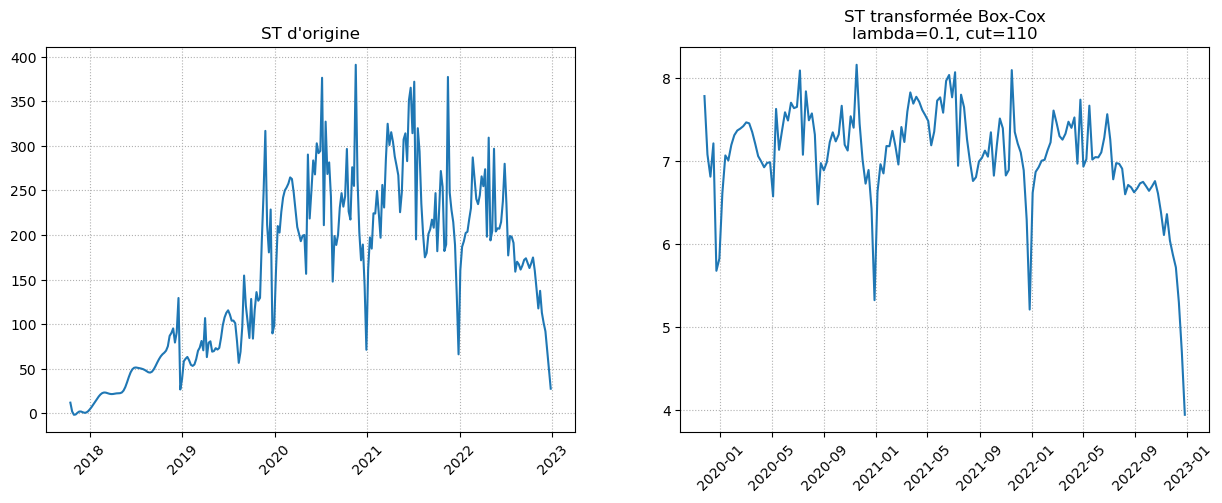

In [10]:
# Transformation Box-Cox du signal 
# ----------------------------------------------
TS_week,lam = dp1.transform_TS(TSrec_week,lam=0.1,cut=110,plot_graph=True) #0.3

#### Décomposition 

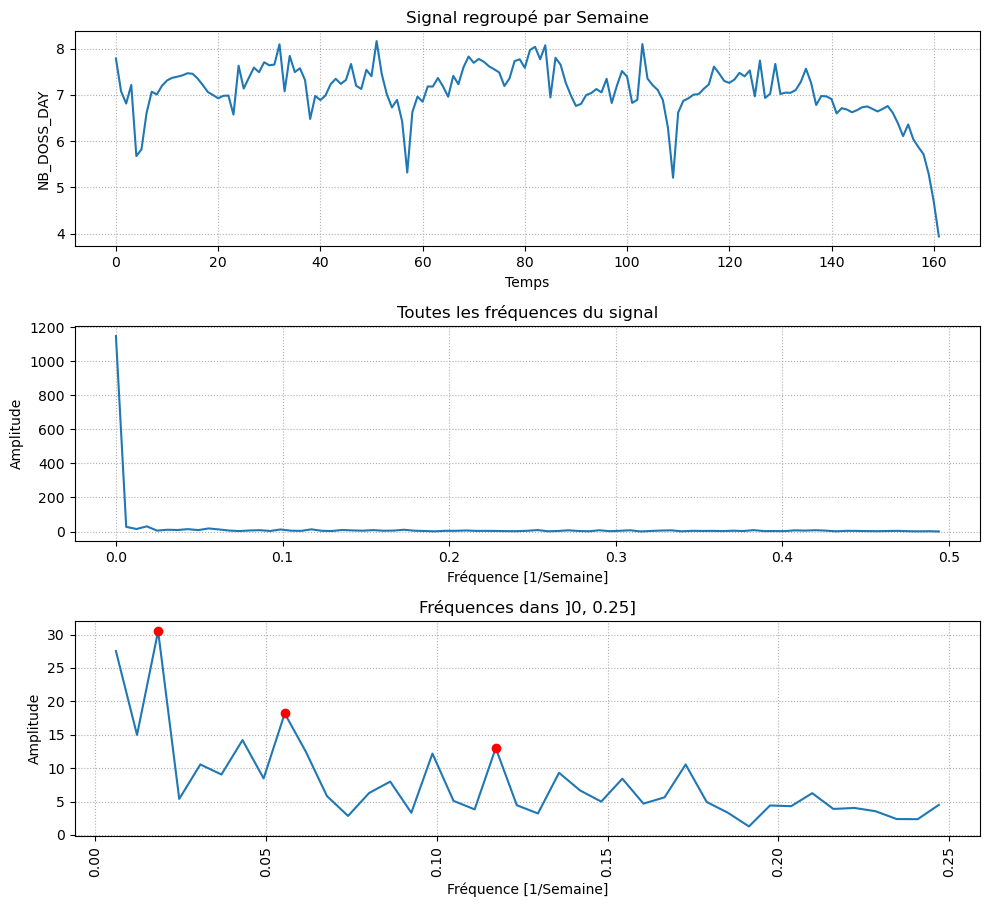

In [11]:
# Tracé du la transformée de Fourier pour déterminer la saisonnalité
# ----------------------------------------------
sa.plot_FFT(TS_week.values,grouped_by='Semaine',thres=10)

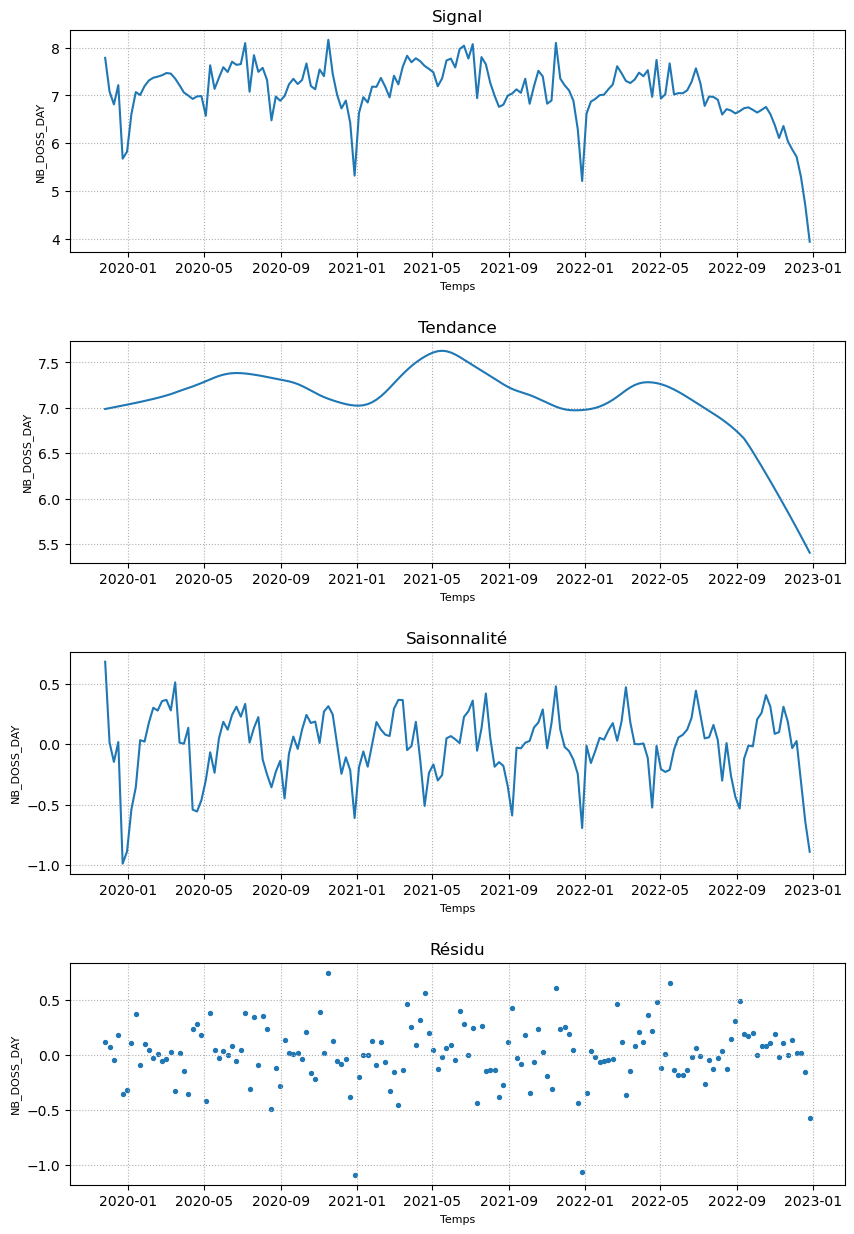

In [12]:
# Décomposition du signal en tendance + saisonnalité + résidu
# ----------------------------------------------
TS_week_season,_,_ = sa.decompose(TS_week,decomposition='STL',period=16,model='additive') #period=20 (if no cut)

#### Correction saisonnalité

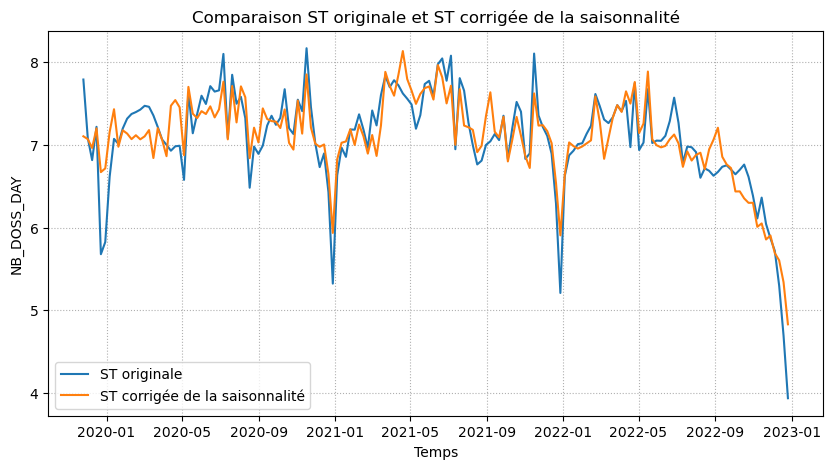

In [13]:
# On retire la saisonnalité de la série temporelle
# ----------------------------------------------
TS_week = sa.correct_season(TS_week,TS_week_season,model='additive',display_graph=True)

#### Sépararation train & test

In [14]:
# Séparation de la série temporelle en train + test
# ----------------------------------------------
TS_train,TS_test,splits = sa.split_train_test_uni(TS_week,k=0.8)

#### Sélection des paramètres

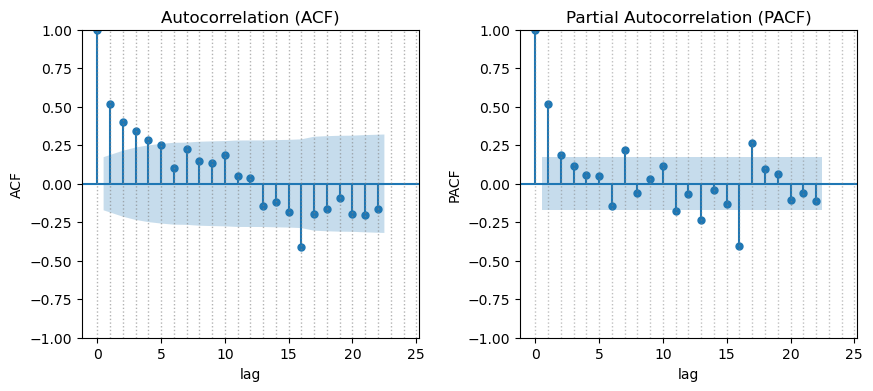

p-value test ADF : 0.10096727568839947
p-value > 0.05 : ST non stationnaire
Ecart type de la ST :  0.356


In [27]:
# Graphiques ACF et PACF permettant de choisir les paramètres ARIMA/SARIMA
# ----------------------------------------------
_ = sa.plot_autocorr_TS(TS_train)

On voit que la série temporelle n'est pas tout à fait stationnaire, or ARIMA/SARIMA nécessite des séries temporelles stationnaires. On peut différencier la série temporelle pour la rendre plus stationnaire où on peut aussi laisser la série temporelle telle quelle car elle est presque stationnaire. 

Les plots ACF/PACF ci-dessus nous permettent aussi de sélectionner les paramètres pour le modèle ARIMA. Pour une documentation précise sur comment choisir les paramètres à l'aide de règles, exécuter `help(sa.plot_autocorr_TS)`

**Choix des paramètres:** On a choisi les paramètres à l'aide des graphes ACF et PACF ci-dessus mais également en effectuant plusieurs tests. 

- Choix différenciation: 

Même si le test ADF indique que la ST n'est PAS stationnaire, on voit que le lag-1 de l'autocorrélation (ACF) est négatif ou nul ce qui indique que l'on ne doit pas différencier davantage la ST d'après la régle 1 (voir `help(sa.plot_autocorr_TS)` pour les règles).

- Choix ARIMA: 

On voit que le plot ACF décroit lentement tandis que PACF décroit de manière brute, on ajoute donc des termes AR au modèle d'après la règle 6 (même si PACF au lag-1 est négative et non positive comme indiqué dans la règle 6). 
Sur le PACF, on voit un pic significatif à lag 7 (positif ou négatif)et d'autres pics plus lointains. On ajoute donc 7 termes AR.

Comme la règle 6 n'est pas tout à fait respectée (PACF lag-1 négative au lieu de positive) et que la règle 7 stipule que si ACF au lag-1 est négative, on peut ajouter des termes MA, on ajoute 2 termes MA au modèle (le nombre 2 a été choisi avec des tests). 

On a donc un modèle ARIMA(7,0,2)

- Choix SARIMA

Avec la fonction plot_FFT et decomposition, nous avions trouvé une saisonnalité de 16. De plus, on observe un pic significatif au lag 16 et 17 sur le plot PACF et on ajoute donc deux termes saisonniers AR. On n'ajoute pas de termes MA saisonniers ni de différenciation saisonnière (les tests n'ayant pas été concluants). 

On a donc un modèle SARIMA(7,0,2)(0,0,2,16)

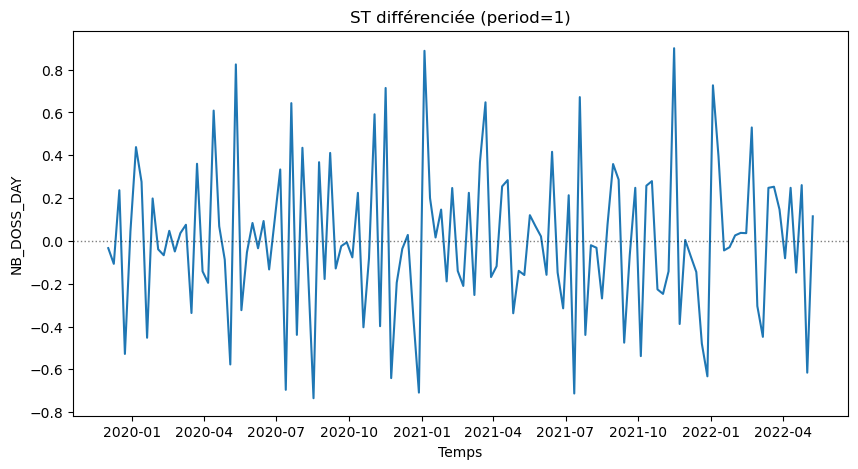

In [16]:
# Différenciation de la série temporelle pour la rendre sationnaire
# ----------------------------------------------
TS_train_diff = sa.diff_TS(TS_train,period=1)

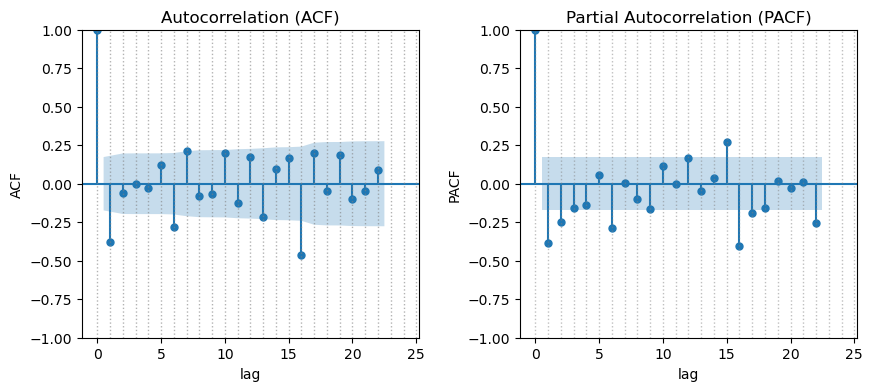

p-value test ADF : 6.649081563970231e-10
p-value < 0.05 : ST stationnaire
Ecart type de la ST :  0.351


In [17]:
# Graphiques ACF et PACF permettant de choisir les paramètres ARIMA/SARIMA
# ----------------------------------------------
_ = sa.plot_autocorr_TS(TS_train_diff)

#### Entraînement du modèle & prédiction

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  129
Model:             ARIMA(7, 0, 2)x(0, 0, 2, 16)   Log Likelihood                 -46.625
Date:                          Tue, 21 Mar 2023   AIC                            117.250
Time:                                  15:37:47   BIC                            151.568
Sample:                              11-25-2019   HQIC                           131.194
                                   - 05-09-2022                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2708      0.009    141.362      0.000       1.253       1.288
ar.L2         -0.0821      0.000   -234.501      0.

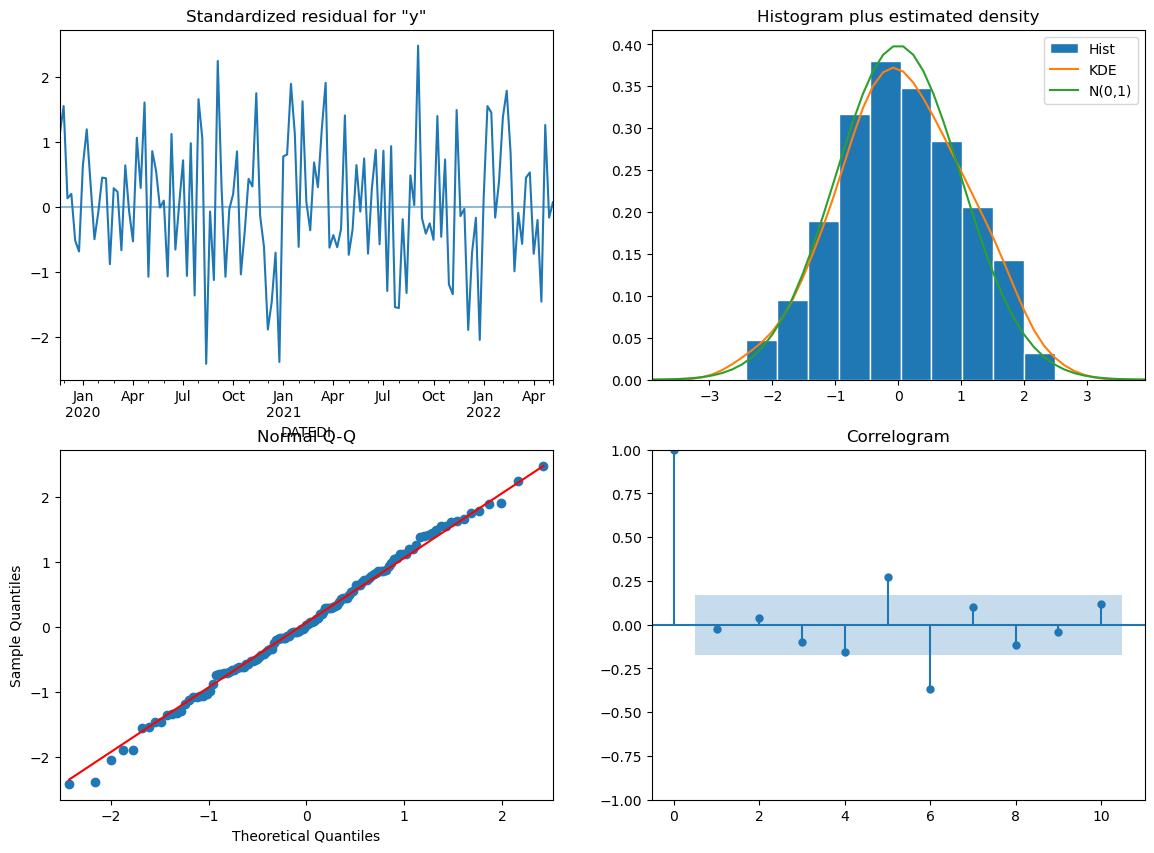

"forecast_test,conf_int = sa.train_SARIMA (TS_train,TS_test,order=(7,0,2),seasonal_order=(0,0,0,0),\n                                      trend='n',all_pred=False,verbose=True) "

In [29]:
# Entraînement de la ST avec les paramètres suivants:
# cut=110, Box-Cox(lambda=0.1), corrigée de la saisonnalité avec period=16 (trouvé avec STL) 
# SARIMA(7,0,2)(0,0,2,16)
# --------------------------------------------------
# SARIMA
forecast_test,conf_int = sa.train_SARIMA (TS_train,TS_test,order=(7,0,2),seasonal_order=(0,0,2,16),
                                      trend='n',all_pred=False,verbose=True)

# ARIMA
"""forecast_test,conf_int = sa.train_SARIMA (TS_train,TS_test,order=(7,0,2),seasonal_order=(0,0,0,0),
                                      trend='n',all_pred=False,verbose=True) """

Valeur moyenne de la ST originale:  7
Valeur moyenne de l'erreur:  0


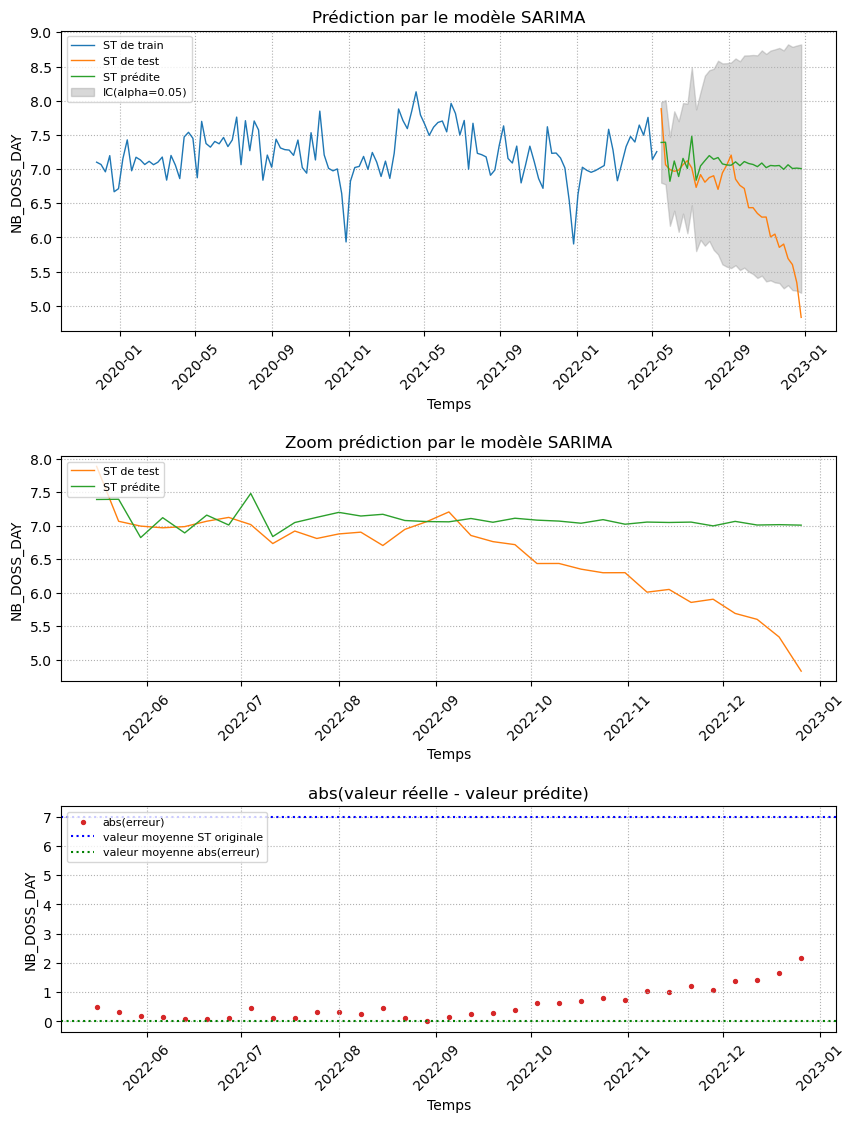

In [30]:
# Tracé de la prédiction de la série temporelle tansformée
# --------------------------------------------------
dp1.plot_prediction(TS_week,forecast_test,splits,conf_int=conf_int,model_name='SARIMA')

Valeur moyenne de la ST originale:  220
Valeur moyenne de l'erreur:  56


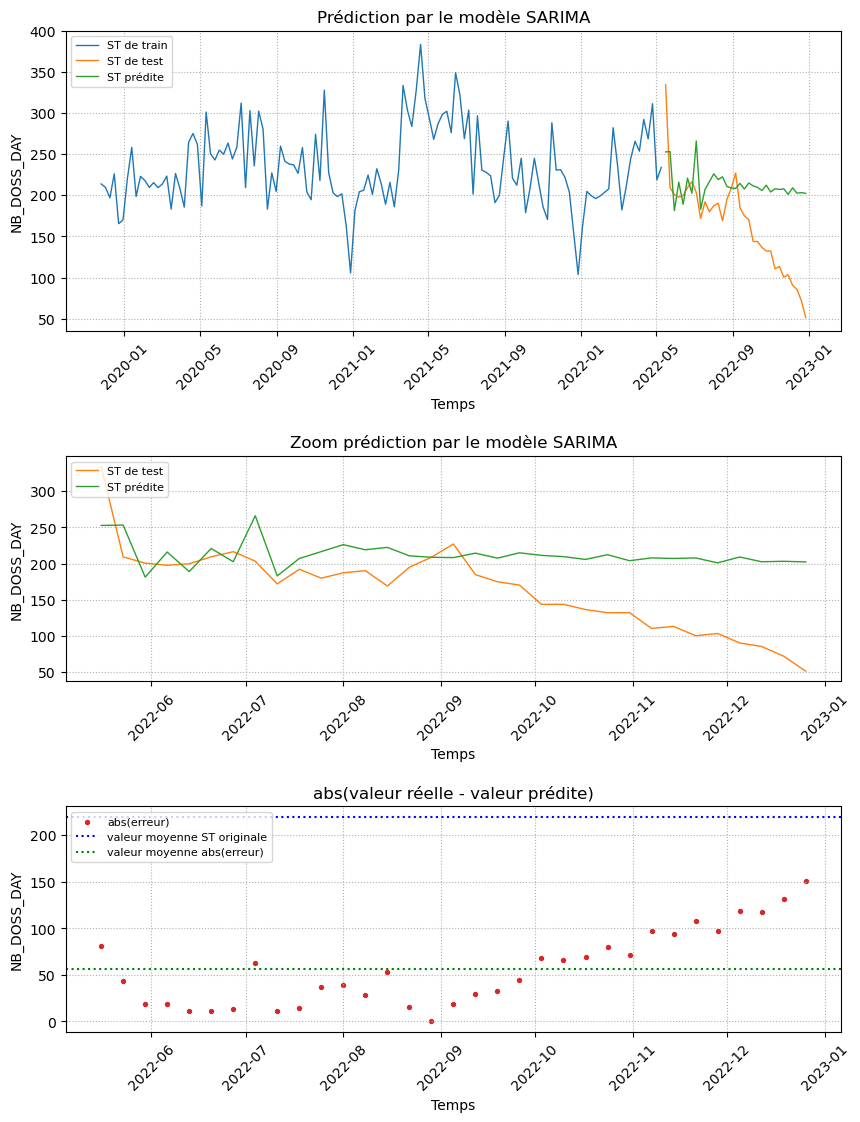

In [31]:
# Tracé de la prédiction de la série temporelle tansformée inverse 
# --------------------------------------------------
TS_week_inv = dp1.transform_inv_TS(TS_week,lam=lam)
forecast_test_inv = dp1.transform_inv_TS(forecast_test,lam=lam)
conf_int_inv = dp1.transform_inv_TS(conf_int,lam=lam)

dp1.plot_prediction(TS_week_inv,forecast_test_inv,splits,conf_int=conf_int_inv*0,model_name='SARIMA')

In [32]:
_ = dp1.compute_rmse(TS_week_inv[splits[1]],forecast_test_inv)
_ = dp1.compute_mae(TS_week_inv[splits[1]],forecast_test_inv)

rmse sur les données de test : 69.09894
mae sur les données de test : 56.25358
